In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:99%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

# ※ naver Open Api를 활용하여 네이버 지식인 "전주 여행"과 "경주 여행"을 검색 -> 명사만 추출(re) -> 빈도분석(DataFrame), 시각화(워드클라우드)

# 1. 네이버 api를 활용하여 두 검색어 추출

In [2]:
import os
import sys
import urllib.request
client_id = "PEdh_oUh_6HvzCnKIEa7"
client_secret = "FPyGzkvQLD"
encText = urllib.parse.quote("경주 여행")
url = "https://openapi.naver.com/v1/search/blog?query=" + encText # JSON 결과
# url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Mon, 30 Dec 2024 16:42:59 +0900",
	"total":876464,
	"start":1,
	"display":10,
	"items":[
		{
			"title":"<b>경주여행<\/b> 대릉원 드론촬영하기! (경주시청허가必)",
			"link":"https:\/\/blog.naver.com\/cooooooook\/223658719098",
			"description":"사진 ⓒ쿠우욱 안녕하세요 여행블로거 쿠우욱입니다 지난 <b>경주여행<\/b>을 떠나기전 경주 유적지들의 드론촬영을 해보고 싶어서 미리 경주시 문화유산과에 촬영 허가를 받고 방문하였습니다 :D 경주대릉원  위치... ",
			"bloggername":"태리네 가족은 여행중",
			"bloggerlink":"blog.naver.com\/cooooooook",
			"postdate":"20241113"
		},
		{
			"title":"<b>경주여행<\/b> 경주힐튼 조식 포함 숙박후기 실내수영장",
			"link":"https:\/\/blog.naver.com\/kkuik20\/223702301723",
			"description":"<b>경주여행<\/b> 경주힐튼 조식 포함 숙박후기 실내수영장 연말 <b>경주 여행<\/b> 오랜만에 와이프와 함께 <b>경주 여행<\/b>을 하게 되었다. 사실 경주 자체가 목적이었다기보다는 와이프 출장건과 더불어 여행과 주변 지역에... ",
			"bloggername":"꾸익의 일상",
			"bloggerlink":"blog.naver.com\/kkuik20",
			"postdate":"20241222"
		},
		{
			"title":"<b>경주 여행<\/b>코스 루지월드에서 만난 보물",
			"link":"https:\/\/blog.naver.com\/dcndb\/223661667998",
			"description":"이번에 처음 간 루지월드지만 나중에 <b>경주여행<\

In [3]:
from requests import get
import time
import os
import json
from html import unescape # &lt; -> <, &gt;-> >
import pandas as pd

In [6]:
# 네이버 API 계정 정보
client_id = 'PEdh_oUh_6HvzCnKIEa7'
client_secret = 'FPyGzkvQLD'
queries = ['전주 여행', '경주 여행']
max_start = 5

In [13]:
query = "전주 여행"
start = 0
headers = {'X-Naver-Client-Id':client_id,
           'X-Naver-Client-Secret':client_secret}
url = f'https://openapi.naver.com/v1/search/kin.json?query={query}&display=100&start={start+1}'
response = get(url, headers=headers)
print(response.text[:500])

{
	"lastBuildDate":"Mon, 30 Dec 2024 17:28:04 +0900",
	"total":47106,
	"start":1,
	"display":100,
	"items":[
		{
			"title":"<b>전주여행<\/b> 대중교통이랑 렌트카중 어떤게 좋을까요?",
			"link":"https:\/\/kin.naver.com\/qna\/detail.naver?d1id=9&dirId=90110&docId=477694429&qb=7KCE7KO8IOyXrO2WiQ==&enc=utf8&section=kin.qna&rank=1&search_sort=0&spq=0",
			"description":"... <b>전주여행<\/b>때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황이 어떤지 궁금합니다. <b>전주여행<\/b> 전주맛집 국내여행 전주달봉이 달봉티비 <b>전주여행<\/b>코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행... "
		},
		


In [14]:
# 데이터를 저장할 파일 생성 (naver_kin.txt)하고 title 저장
file_name = 'data/naver_kin.txt'
with open(file_name, 'w', encoding='utf-8') as file:
    file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format('query', 
                            'no','title','link', 'description', 'total_text'))

In [16]:
elements = json.loads(response.text)['items']
elements[0]

{'title': '<b>전주여행</b> 대중교통이랑 렌트카중 어떤게 좋을까요?',
 'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90110&docId=477694429&qb=7KCE7KO8IOyXrO2WiQ==&enc=utf8&section=kin.qna&rank=1&search_sort=0&spq=0',
 'description': '... <b>전주여행</b>때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황이 어떤지 궁금합니다. <b>전주여행</b> 전주맛집 국내여행 전주달봉이 달봉티비 <b>전주여행</b>코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행... '}

In [22]:
for i, element in enumerate(elements):
    title = element['title'].replace('<b>', ' ').replace('</b>', ' ')
    link = element['link']
    description = element['description'].replace('<b>', ' ').replace('</b>', ' ')
    description = unescape(description) # html 특수문자 처리(&lt; -> <로 대체)
    # print(query, (start*100+i+1), title, link, description, title+' ' +description)
    with open(file_name, 'a', encoding='utf-8') as file:
        file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(query, 
                                                     start*100+i+1,
                                                     title,
                                                     link,
                                                     description, 
                                                     title + ' ' +description))

In [23]:
df = pd.read_csv('data/naver_kin.txt', sep='\t')
df.head(2)

,query,no,title,link,description,total_text
0,전주 여행,1,전주여행 대중교통이랑 렌트카중 어떤게 좋을까요?,https://kin.naver.com/qna/detail.naver?d1id=9&...,... 전주여행 때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황...,전주여행 대중교통이랑 렌트카중 어떤게 좋을까요? ... 전주여행 때 움직이기 ...
1,전주 여행,2,전주여행 갈려고하는데요!,https://kin.naver.com/qna/detail.naver?d1id=9&...,전주여행 을 갈려고하는데요!아는사람과 갈려고하는데 호텔은 좋은가격에 정했고~ 음....,전주여행 갈려고하는데요! 전주여행 을 갈려고하는데요!아는사람과 갈려고하는데 호텔...


# 내일(12.31)

In [2]:
from requests import get
import time
import os
import json
from html import unescape # &lt; -> <, &gt;-> >
import pandas as pd

In [3]:
# 네이버 API 계정 정보
client_id = 'PEdh_oUh_6HvzCnKIEa7'
client_secret = 'FPyGzkvQLD'
queries = ['전주 여행', '경주 여행']
max_start = 5

In [4]:
def get_search_element_save(query, start):
    headers = {'X-Naver-Client-Id':client_id,
           'X-Naver-Client-Secret':client_secret}
    url = f'https://openapi.naver.com/v1/search/kin.json?query={query}&display=100&start={start+1}'
    response = get(url, headers=headers)
    elements = json.loads(response.text)['items']
    for i, element in enumerate(elements):
        title = element['title'].replace('<b>', ' ').replace('</b>', ' ')
        link = element['link']
        description = element['description'].replace('<b>', ' ').replace('</b>', ' ')
        description = unescape(description) # html 특수문자 처리(&lt; -> <로 대체)
        # print(query, (start*100+i+1), title, link, description, title+' ' +description)
        with open(file_name, 'a', encoding='utf-8') as file:
            file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(query, 
                                                         start*100+i+1,
                                                         title,
                                                         link,
                                                         description, 
                                                         title + ' ' +description))

In [5]:
# 데이터를 저장할 파일 생성 (naver_kin.txt)하고 title 저장
file_name = 'data/naver_kin.txt'
with open(file_name, 'w', encoding='utf-8') as file:
    file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format('query', 
                            'no','title','link', 'description', 'total_text'))

In [8]:
for query in queries:
    for start in range(max_start):
        print(start, query, '읽고 파일 쓰기 중')
        get_search_element_save(query, start)
        time.sleep(0.3)

0 전주 여행 읽고 파일 쓰기 중
1 전주 여행 읽고 파일 쓰기 중
2 전주 여행 읽고 파일 쓰기 중
3 전주 여행 읽고 파일 쓰기 중
4 전주 여행 읽고 파일 쓰기 중
0 경주 여행 읽고 파일 쓰기 중
1 경주 여행 읽고 파일 쓰기 중
2 경주 여행 읽고 파일 쓰기 중
3 경주 여행 읽고 파일 쓰기 중
4 경주 여행 읽고 파일 쓰기 중


# 2. 품사 태깅 저장

In [9]:
df = pd.read_csv('data/naver_kin.txt', sep='\t')
df.sample()

,query,no,title,link,description,total_text
998,경주 여행,499,부모님과 애들하고 경주여행 문의 드립니다.,https://kin.naver.com/qna/detail.naver?d1id=9&...,"... 3살 딸래미, 4개월 된 아들 이렇게 경주 여행 하려 합니다. 오래 걷지...","부모님과 애들하고 경주여행 문의 드립니다. ... 3살 딸래미, 4개월 된 아들..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query        1000 non-null   object
 1   no           1000 non-null   int64 
 2   title        1000 non-null   object
 3   link         1000 non-null   object
 4   description  1000 non-null   object
 5   total_text   1000 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


In [12]:
# 데이터 프레임은 for문을 돌릴 경우 컬럼명만 적용
for row in df:
    print(row)

(0, 'query')
(1, 'no')
(2, 'title')
(3, 'link')
(4, 'description')
(5, 'total_text')


In [18]:
# 데이터 프레임을 for문 적용을 위해 list로 형변환
df_list = df[['query','no','total_text']].values.tolist()
print(type(df_list))
print(df_list[::250])

<class 'list'>
[['전주 여행', 1, ' 전주여행  대중교통이랑 렌트카중 어떤게 좋을까요? ...  전주여행 때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황이 어떤지 궁금합니다.  전주여행  전주맛집 국내여행 전주달봉이 달봉티비  전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행... '], ['전주 여행', 251, '내일  전주  당일치기 부모님과  여행 을 ...  전주여행  전주맛집 국내여행 전주달봉이 달봉티비  전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 제주도가볼만한곳 여행 전문 인플루언서 전주달봉이입니다. 바다는 군산 새만금 돌아보시면... '], ['경주 여행', 1, '추석에  경주 여행  추석에  경주 여행  가는거 어떻게 생각하시나요? 서울에서 버스를 타고 갈 경우, 버스가 버스전용 차선에서 운행하나요?... 질문하신 [추석  경주여행 ] 관련 답변 드리도록 하겠습니다. 첨성대, 석굴암, 불국사 등 유적지는 연중무휴로... '], ['경주 여행', 251, '[추천해주세요]  경주여행  [추천해주세요]  경주여행  안녕하세요~~ 무계획 이 루트로 이용시 실패없는  경주여행  소개해드릴까 합니다 ㅎㅎ 한번 보시고 마음에 드신다면 채택 부탁드립니다~~']]


In [21]:
# ㅠ, 음, ㅋㅋ, ㅎㅎ
import re
text = '음. 경주ㅎㅎ좋아요 ㅎㅎ 진짜 일까? ㅠㅠ'
re.sub('[^가-힣\s]', ' ', text) # ^ : 반대

'음  경주  좋아요    진짜 일까    '

In [165]:
file_name = 'data/naver_kin_pos.csv'
with open(file_name, 'w', encoding='cp949') as file:
    file.write('{},{},{},{}\n'.format('query','no','token', 'pos'))

In [20]:
from konlpy.tag import Hannanum, Kkma, Komoran, Okt
from mecab import MeCab
stopwords = ['여행','전주','경주']
# 원하는 품사 : 일반명사, 고유명사
select_pos = ['N'] # Hannanum(ntags=9)
# select_pos = ['NC','NQ'] # Hannanum(ntags=22)
# select_pos = ['NNG', 'NNP'] # Kkma, Komoran, MeCab
# select_pos = ['Noun'] # Okt

In [166]:
# pos_tagger = Hannanum() #띄어쓰기 단위로 형태소 분석
# pos_tagger = Kkma() # 속도 성능 최저
#pos_tagger = Komoran() # 띄어쓰기를 안해도 최선을 다해 형태소분석
pos_tagger = MeCab()
for i, row in enumerate(df_list):
    query = row[0]
    no    = row[1]
    text  = row[2]
    # print('수정전 :', text)
    text = re.sub('[^가-힣\s]', ' ', text)
    text = re.sub('\s+', ' ', text)
    # print('수정후 :', text, end='\n\n')
    text_pos = pos_tagger.pos(text)
    # text_pos = pos_tagger.pos(text, 22) # Hannanum (ntags=22)
    if i%250 == 0:
        print(query, no, len(text_pos), text, end='\n\n')
    for token, pos in text_pos:
        # if token not in stopwords and pos in select_pos and len(token)>1 : # 명사만 저장
        if token not in stopwords and len(token)>1 : # 모든 품사를 우선 다 저장
            with open(file_name, 'a') as file:
                file.write('{},{},{},{}\n'.format(query,no,token, pos))

전주 여행 1 63  전주여행 대중교통이랑 렌트카중 어떤게 좋을까요 전주여행 때 움직이기 차가 편할지 대중교통이 편할지 알려주세요 교통 상황이 어떤지 궁금합니다 전주여행 전주맛집 국내여행 전주달봉이 달봉티비 전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 

전주 여행 251 64 내일 전주 당일치기 부모님과 여행 을 전주여행 전주맛집 국내여행 전주달봉이 달봉티비 전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 제주도가볼만한곳 여행 전문 인플루언서 전주달봉이입니다 바다는 군산 새만금 돌아보시면 

경주 여행 1 55 추석에 경주 여행 추석에 경주 여행 가는거 어떻게 생각하시나요 서울에서 버스를 타고 갈 경우 버스가 버스전용 차선에서 운행하나요 질문하신 추석 경주여행 관련 답변 드리도록 하겠습니다 첨성대 석굴암 불국사 등 유적지는 연중무휴로 

경주 여행 251 42  추천해주세요 경주여행 추천해주세요 경주여행 안녕하세요 무계획 이 루트로 이용시 실패없는 경주여행 소개해드릴까 합니다 한번 보시고 마음에 드신다면 채택 부탁드립니다 



# 3. 명사만 추출하여 빈도분석

In [167]:
df = pd.read_csv('data/naver_kin_pos.csv', encoding='cp949')
df.tail(2)

,query,no,token,pos
23806,경주 여행,500,가족,NNG
23807,경주 여행,500,함께,MAG


In [168]:
# 명사만
# Hannanum(ntags=22) ['NC','NQ'] # 
# Kkma, Komoran, MeCab ['NNG', 'NNP'] # 
# Okt ['Noun'] 
df_flt = df.loc[(df['pos']=='NNG') | (df['pos']=='NNP'), ['query','token','pos']]
df_flt = df.loc[df['pos'].isin(['NNG', 'NNP']), ['query','token','pos']]
df_flt.iloc[::5000]

,query,token,pos
0,전주 여행,대중교통,NNG
7827,전주 여행,제주도,NNP
16151,경주 여행,거리,NNG


In [169]:
# query별 token별 count수(빈도수)
# df_flt.groupby(['query','token']).count() # 소트 작업이 필요
df_grp = df_flt.groupby('query')['token'].value_counts() # 소트 포함
df_grp

query  token
경주 여행  코스       484
       추천       401
       숙소       178
       계획       137
       질문       133
               ... 
전주 여행  레일바이크      2
       수지         2
       아중         2
       대전         1
       상황         1
Name: token, Length: 899, dtype: int64

In [170]:
# df_grp의 index을 컬럼으로 
df_idx = df_grp.reset_index(name='count')
df_idx.iloc[::240]

,query,token,count
0,경주 여행,코스,484
240,경주 여행,궁터,5
480,전주 여행,한옥,111
720,전주 여행,변호,5


In [171]:
# 전주 여행, 경주 여행 빈도 추출 -> 병합
a = pd.DataFrame([['단어1', 52],
                  ['단어2', 12]], columns=['단어','count'])
b = pd.DataFrame([['단어1', 90],
                  ['단어3', 52]], columns=['단어','count'])
# display(a)
# display(b)
ab = pd.merge(a, b,
             how='outer',  # inner(공통), left(a기준), right(b기준)
             on='단어') # 두 프레임을 어떤 열 기준으로 병합할지 열이름
ab.fillna(0, inplace=True)
ab.columns = ['단어','경주빈도','전주빈도']
ab['경주빈도'] = ab['경주빈도'].astype('int')
import numpy as np
ab['전주빈도'] = ab['전주빈도'].astype(np.int16) # 'int16'
ab

,단어,경주빈도,전주빈도
0,단어1,52,90
1,단어2,12,0
2,단어3,0,52


In [172]:
df_gj = df_idx.loc[df_idx['query']=='경주 여행', ['token','count']]
df_jj = df_idx.loc[df_idx['query']=='전주 여행', ['token','count']]
df_gj.shape, df_jj.shape

((467, 2), (432, 2))

In [173]:
df_gj.head(10)

,token,count
0,코스,484
1,추천,401
2,숙소,178
3,계획,137
4,질문,133
5,답변,123
6,부탁,115
7,가족,101
8,일정,99
9,관련,86


In [174]:
df_gj.sort_values(by='count', ascending=False).index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            447, 446, 445, 444, 461, 462, 463, 464, 465, 466],
           dtype='int64', length=467)

In [175]:
df_mrg = pd.merge(df_gj, df_jj,
                 how='outer',
                 on='token')
df_mrg.columns = ['token','경주빈도','전주빈도']
df_mrg.fillna(0, inplace=True)
df_mrg['경주빈도'] = df_mrg['경주빈도'].astype('int16')
df_mrg['전주빈도'] = df_mrg['전주빈도'].astype(np.int16)
df_mrg.head(10)

,token,경주빈도,전주빈도
0,코스,484,489
1,추천,401,350
2,숙소,178,76
3,계획,137,35
4,질문,133,95
5,답변,123,65
6,부탁,115,79
7,가족,101,15
8,일정,99,80
9,관련,86,35


In [176]:
df_mrg['빈도합'] = df_mrg['경주빈도'] + df_mrg['전주빈도']
df_mrg.sort_values(by='빈도합', ascending=False, inplace=True)

In [177]:
df_mrg['경주비율'] = df_mrg['경주빈도']/df_mrg['빈도합']
df_mrg['전주비율'] = df_mrg['전주빈도']/df_mrg['빈도합']
df_mrg = df_mrg.reset_index(drop=True)
df_mrg.head()

,token,경주빈도,전주빈도,빈도합,경주비율,전주비율
0,코스,484,489,973,0.497431,0.502569
1,추천,401,350,751,0.533955,0.466045
2,맛집,65,271,336,0.193452,0.806548
3,여수,0,319,319,0.000000,1.000000
4,주달,0,278,278,0.000000,1.000000


In [178]:
# 비율은 컬럼은 %
def method(x):
    return "{:.2%}".format(x)
method(0.0068)

'0.68%'

In [179]:
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg['전주비율'] = df_mrg['전주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg.head()

,token,경주빈도,전주빈도,빈도합,경주비율,전주비율
0,코스,484,489,973,49.74%,50.26%
1,추천,401,350,751,53.40%,46.60%
2,맛집,65,271,336,19.35%,80.65%
3,여수,0,319,319,0.00%,100.00%
4,주달,0,278,278,0.00%,100.00%


In [180]:
df_mrg[df_mrg['token'].isin(['경주여행','전주여행'])]

,token,경주빈도,전주빈도,빈도합,경주비율,전주비율


In [182]:
df_mrg.to_csv('data/naver_kin_count.csv', encoding='cp949', index=False)

# 4. 워드 클라우드
- 전주여행 명사만, 경주여행 명사만

In [184]:
df_flt['pos'].unique()

array(['NNG', 'NNP'], dtype=object)

In [187]:
df_flt.iloc[::3000]

,query,token,pos
0,전주 여행,대중교통,NNG
4691,전주 여행,시작,NNG
9375,전주 여행,추천,NNG
14379,경주 여행,문화,NNG
19737,경주 여행,맛집,NNG


In [192]:
# 전주 여행 token들, 경주여행 token들
jj_noun_list = df_flt.loc[df_flt['query']=='전주 여행', 'token'].tolist()
gj_noun_list = df_flt.loc[df_flt['query']=='경주 여행', 'token'].tolist()
print(jj_noun_list[:10])
print(gj_noun_list[:10])

['대중교통', '렌트카', '대중교통', '교통', '상황', '맛집', '국내', '주달', '티비', '코스']
['추석', '추석', '생각', '서울', '버스', '경우', '버스', '버스', '전용', '차선']


In [194]:
df_grp = df_flt.groupby('query')['token'].apply(list)
df_grp

query
경주 여행    [추석, 추석, 생각, 서울, 버스, 경우, 버스, 버스, 전용, 차선, 운행, 질...
전주 여행    [대중교통, 렌트카, 대중교통, 교통, 상황, 맛집, 국내, 주달, 티비, 코스, ...
Name: token, dtype: object

In [196]:
jj_noun_list = df_grp['전주 여행']
gj_noun_list = df_grp['경주 여행']
print(jj_noun_list[:10])
print(gj_noun_list[:10])

['대중교통', '렌트카', '대중교통', '교통', '상황', '맛집', '국내', '주달', '티비', '코스']
['추석', '추석', '생각', '서울', '버스', '경우', '버스', '버스', '전용', '차선']


In [201]:
gyeongju = ' '.join(gj_noun_list)
jeonju   = ' '.join(jj_noun_list)
print(jeonju[:30])
print(gyeongju[:30])

대중교통 렌트카 대중교통 교통 상황 맛집 국내 주달 티
추석 추석 생각 서울 버스 경우 버스 버스 전용 차선 


In [202]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

- 컬러맵
    - https://matplotlib.org/tutorials/colors/colormaps.html

In [203]:
font_path = 'data/NanumPenScript-Regular.ttf'
color_map = 'viridis'

<function matplotlib.pyplot.show(close=None, block=None)>

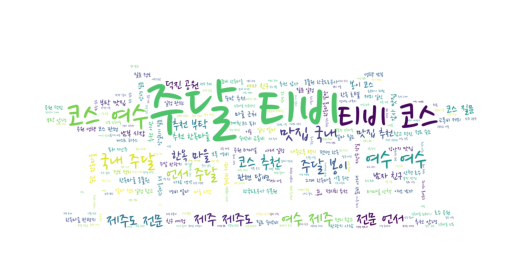

In [214]:
from PIL import Image
mask = np.array(Image.open('data/korea-house-black-fill.png'))
불용어 = set(['경주여행','전주여행'])
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',
    colormap=color_map,
    max_words = 300,
    max_font_size = 200,
    scale=2, # 이미지 크기의 비율(값이 클수록 이미지 저장시 선명도가 높아짐)
    stopwords=불용어,
    mask=mask,
    random_state=4 # 랜덤 시드값을 맞추면 같은 모양의 워드 클라우드 생성
).generate(jeonju)
plt.imshow(wordcloud)
plt.axis('off')
plt.show

In [215]:
# 생성된 wordcloud 이미지 저장
wordcloud.to_file('data/jeonju_could.jpg')

<function matplotlib.pyplot.show(close=None, block=None)>

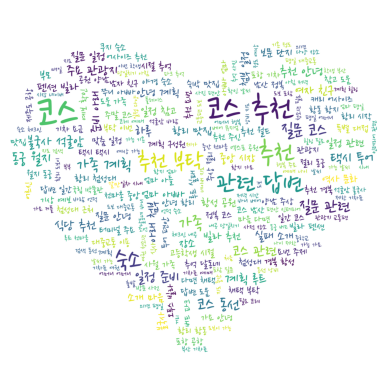

In [220]:
from PIL import Image
mask = np.array(Image.open('data/heart.jpg'))
불용어 = set(['경주여행','전주여행'])
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',
    colormap=color_map,
    max_words = 200,
    max_font_size = 200,
    scale=3, # 이미지 크기의 비율(값이 클수록 이미지 저장시 선명도가 높아짐)
    stopwords=불용어,
    mask=mask,
    random_state=4 # 랜덤 시드값을 맞추면 같은 모양의 워드 클라우드 생성
).generate(gyeongju)
plt.imshow(wordcloud)
plt.axis('off')
plt.show

In [221]:
# 생성된 wordcloud 이미지 저장
wordcloud.to_file('data/gyeongju_could.png')